# Análise ENEM 2017-2019

Aplicação de Machine Learning nos microdados já explorados do ENEM 2017, 2018 e 2019, visto que houve erro com os microdados dos anos anteriores.

In [1]:
## Caso o Google Drive não estiver montado ainda, retirar os comentários das linhas de código abaixo
## (aquelas que possuem somente um '#').

## ATENÇÃO! Aparecerá um link externo seguro provido automaticamente pelo Google Colab para que seja 
## gerado o código de autenticação necessário para o acesso ao Drive.

## Linhas de código a descomentar:

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

Bibliotecas utilizadas:

- *pandas*: para carregar os dados em um dataframe.

- *numpy*: para realizar operações numéricas

- *seaborn*: para plotar gráficos estatisticos

- *matplotlib*: para plotar gráficos

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dados Pré-processados

Os dados a serem utilizados foram pré-processados para facilitar suas aplicações. O código abaixo os copiará do Drive para o Colaboratory.

In [3]:
# Dados do ENEM 2017
enem2017data_path = '/content/drive/MyDrive/Colab Notebooks/Dados/DF_ENEM_2017.csv'
df_enem2017 = pd.read_csv(enem2017data_path, encoding='latin-1')

# Dados do ENEM 2018
enem2018data_path = '/content/drive/MyDrive/Colab Notebooks/Dados/DF_ENEM_2018.csv'
df_enem2018 = pd.read_csv(enem2018data_path, encoding='latin-1')

# Dados do ENEM 2019
enem2019data_path = '/content/drive/MyDrive/Colab Notebooks/Dados/DF_ENEM_2019.csv'
df_enem2019 = pd.read_csv(enem2019data_path, encoding='latin-1')

In [4]:
# Dados do ENEM concatenados
df_enem = pd.concat([df_enem2017, df_enem2018, df_enem2019])

In [5]:
df_enem.shape 

(3547820, 42)

In [6]:
df_enem.isna().sum()

NU_INSCRICAO              0
NU_ANO                    0
CO_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_ESTADO_CIVIL           0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
IN_TREINEIRO              0
IN_SEM_RECURSO            0
Q001                      0
Q002                      0
Q003                      0
Q004                      0
Q005                      0
Q006                      0
Q007                      0
Q008                      0
Q009                      0
Q010                      0
Q011                      0
Q012                      0
Q013                      0
Q014                      0
Q015                      0
Q016                      0
Q017                      0
Q018                      0
Q019                      0
Q020                      0
Q021                      0
Q022                

# ML - Feature Selection

Como o dataset é composto por números não-negativos, foi preferido realizar uma normalização entre 0 e 1 com *MinMaxScaler()* no lugar de uma padronização com média e desvio padrão como com *StandardScaler()*. 

Já que a intenção é ter a ideia do papel dos dados socioeconômicos nas notas, a variável alvo a ser escolhida é NU_MEDIA_NOTAS

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression ## mutual_info_regression eats up whole available RAM
from sklearn.model_selection import train_test_split

In [8]:
df_Y = df_enem['NU_MEDIA_NOTAS']
df_X = df_enem.drop(['NU_INSCRICAO', 'NU_MEDIA_NOTAS'], axis=1)
df_X.reset_index(drop=True, inplace=True)

X = df_enem.loc[:,df_X.columns].values

X = MinMaxScaler().fit_transform(X)

Convertendo os dados normalizados em um DataFrame

In [9]:
df_X_norm = pd.DataFrame(X, columns=df_X.columns)
df_X_norm.head()

,NU_ANO,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,IN_SEM_RECURSO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,0.0,0.047619,0.185185,0.0,0.0,0.6,0.50,0.0,0.0,0.5,0.0,0.0,0.0,0.571429,0.857143,1.0,0.6,0.263158,0.9375,1.0,0.75,1.00,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.0,1.0,1.00,1.0,1.0,1.00,1.0,1.00,1.0,0.0,0.0
1,0.0,0.428571,0.358025,1.0,0.0,0.4,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.857143,0.857143,1.0,1.0,0.105263,1.0000,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0
2,0.0,0.571429,0.185185,1.0,0.0,0.6,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.571429,0.2,0.2,0.210526,0.3125,0.0,0.25,0.50,0.00,0.00,0.25,0.25,0.25,0.00,0.25,0.0,0.0,0.50,1.0,0.0,0.75,1.0,0.25,1.0,0.0,0.0
3,0.0,0.571429,0.197531,1.0,0.0,0.4,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.428571,0.6,0.4,0.157895,0.1875,0.0,0.25,0.25,0.25,0.00,0.25,0.00,0.25,0.00,0.25,0.0,1.0,0.25,1.0,0.0,0.75,0.0,0.25,1.0,0.0,0.0
4,0.0,0.428571,0.185185,0.0,0.0,0.2,0.25,0.0,0.0,0.5,0.0,0.0,0.0,0.285714,0.714286,0.2,0.6,0.263158,0.0625,0.0,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.25,0.0,0.0,0.0


Selecionar agora as 5 features mais relevantes segundo a *f_regression* e *mutual_info_regression*

In [10]:
# Utilizando f_regression (F-score)
f_X = SelectKBest(score_func=f_regression, k=7)
f_X = f_X.fit(df_X_norm, df_Y) 
f_X_idx = f_X.get_support()
X_new_f = df_X_norm.loc[:,f_X_idx].columns.tolist() 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [11]:
X_new_f # As 7 features selecionadas por SelectKBest()

['TP_ESCOLA', 'Q002', 'Q006', 'Q008', 'Q010', 'Q019', 'Q024']

Separando os conjuntos train e test 

In [12]:
df_X_new = df_X_norm[X_new_f] # Somente com as features selecionadas

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X_new, df_Y, test_size = 0.25, shuffle=True  # 75% train_data - 25% test_data
)

In [13]:
X_train.shape, Y_train.shape

((2660865, 7), (2660865,))

# ML - Prever Notas do ENEM

Para testar a Feature Selection, será implementado um algoritmo para prever as notas com as features selecionadas.

In [14]:
from keras.models import Sequential
from keras.layers import Dense

Criando a estrutura do modelo da rede neural

In [15]:
# Inicializa o construtor
model = Sequential()

# Adiciona a camada de entrada, camada escondida e camada de saída
model.add(Dense(5, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

Treinando a rede neural

In [16]:
history = model.fit(X_train, Y_train, epochs=7, verbose=1, validation_split=0.2)

Epoch 1/7
66522/66522 [==============================] - 67s 1ms/step - loss: 16308.7139 - mse: 16308.7139 - mae: 80.2453 - val_loss: 4141.3843 - val_mse: 4141.3843 - val_mae: 51.5376
Epoch 2/7
66522/66522 [==============================] - 68s 1ms/step - loss: 4132.3433 - mse: 4132.3433 - mae: 51.4478 - val_loss: 4111.1777 - val_mse: 4111.1777 - val_mae: 51.3721
Epoch 3/7
66522/66522 [==============================] - 68s 1ms/step - loss: 4116.2837 - mse: 4116.2837 - mae: 51.3400 - val_loss: 4105.5703 - val_mse: 4105.5703 - val_mae: 51.3087
Epoch 4/7
66522/66522 [==============================] - 67s 1ms/step - loss: 4113.4614 - mse: 4113.4614 - mae: 51.3163 - val_loss: 4104.5542 - val_mse: 4104.5542 - val_mae: 51.3083
Epoch 5/7
66522/66522 [==============================] - 67s 1ms/step - loss: 4112.6387 - mse: 4112.6387 - mae: 51.3090 - val_loss: 4103.2603 - val_mse: 4103.2603 - val_mae: 51.3280
Epoch 6/7
66522/66522 [==============================] - 68s 1ms/step - loss: 4112.1948 

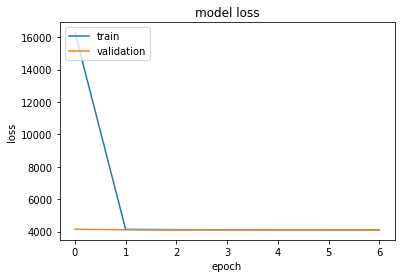

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Teste e Evaluate

In [18]:
# Testando o modelo
y_pred = model.predict(X_test)

In [19]:
# Evaluating
score = model.evaluate(X_test, y_pred, verbose=1)
print(score)

27718/27718 [==============================] - 32s 1ms/step - loss: 3.8109e-10 - mse: 3.8109e-10 - mae: 7.4929e-06
[3.810877724497175e-10, 3.810877724497175e-10, 7.49294440538506e-06]
